imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

loading the dataset and inspecting it for the 6.023 * 10(exp(23))rd time

In [3]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="data", download=False)

I0000 00:00:1755278891.993209   22622 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5012 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

downloading the imdb_vocab_subwords txtfile online

In [5]:
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='imdb_vocab_subwords.txt'
)

2025-08-15 22:58:14.954990: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2025-08-15 22:58:14.955440: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


hyperparameters

In [6]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 128
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

data pipeline

In [7]:
def padding_func(sequences):

  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [8]:
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

2025-08-15 22:58:21.621594: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


building and compiling the model

In [9]:
EMBEDDING_DIM = 64
LSTM_DIM = 64
DENSE_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 563,009 (2.15 MB)

 Trainable params: 563,009 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

training the final model

In [11]:
NUM_EPOCHS = 10

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1755278918.521152   22706 cuda_dnn.cc:529] Loaded cuDNN version 91002


196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.6545 - loss: 0.5905 - val_accuracy: 0.8309 - val_loss: 0.3881
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 264ms/step - accuracy: 0.8458 - loss: 0.3730 - val_accuracy: 0.8320 - val_loss: 0.3924
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - accuracy: 0.8532 - loss: 0.3523 - val_accuracy: 0.8328 - val_loss: 0.3995
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8658 - loss: 0.3308 - val_accuracy: 0.8093 - val_loss: 0.4317
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.8777 - loss: 0.3133 - val_accuracy: 0.8353 - val_loss: 0.4055
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.9096 - loss: 0.2434 - val_accuracy: 0.8113 - val_loss: 0.4357
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.9076 - loss: 0.2532 - val_accuracy: 0.8416 - val_loss: 0.3935
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.9285 - loss: 0.2035 - val

visualizing results

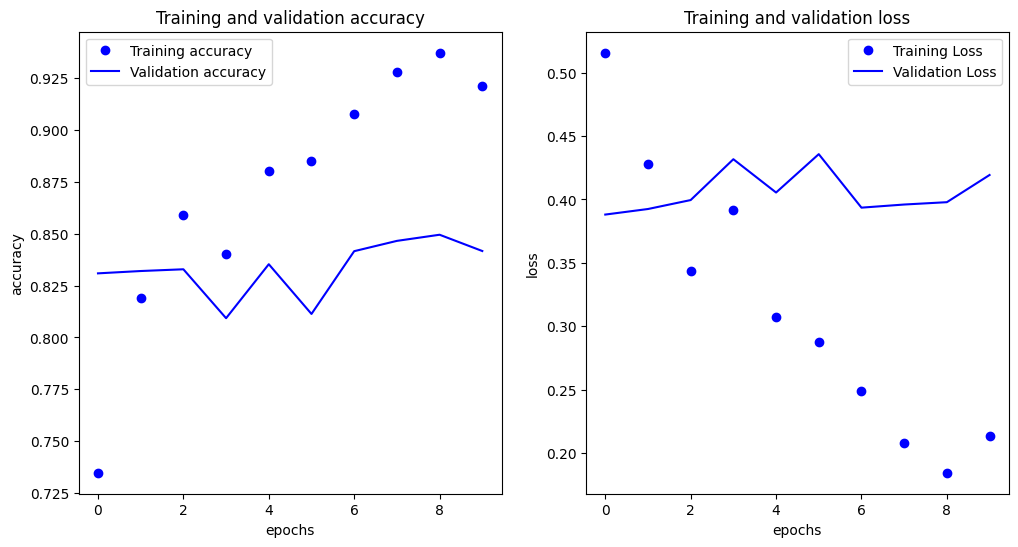

In [12]:
def plot_loss_acc(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)